## *Text Classification Using Unsupervised Learning Techniques*

This code complements my diploma thesis on "Text Classification Using Unsupervised Learning Techniques" for the Electrical and Computer Engineering Department of Aristotle University of Thessaloniki, Greece.

Author: Kitsios Konstantinos

Correspondance address: kitsiosk@ece.auth.gr

Code sub-routines and pretrained neural networks are used from the research papers below:

[1]: D. Cer, Y. Yang, S. yi Kong, N. Hua, N. Limtiaco, R. S. John, N. Constant,M. Guajardo-Cespedes, S. Yuan, C. Tar, Y.-H. Sung, B. Strope, and R. Kurzweil, ‘‘Universalsentence encoder,’’arXiv preprint arXiv:1803.11175, 2018.

[2]: A. Radford, J. Wu, R. Child, D. Luan, D. Amodei, and I. Sutskever, ‘‘Language models areunsupervised multitask learners,’’, 2019.

[3]: N. Pitsianis, A. Iliopoulos, D. Floros, and X. Sun, ‘‘Spaceland embedding of sparsestochastic graphs,’’2019 IEEE High Performance Extreme Computing Conference (HPEC),pp. 1-8, 2019.



## Load Universal Sentence Encoder [1]

In [ ]:
!pip3 install --quiet "tensorflow>=1.7"
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

In [ ]:
# Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
modelEval2 = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return modelEval2(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Define Helper Functions

In [ ]:
import torch
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6) # Cosine Similarity function

In [ ]:
# Embed a sentence batch into R^N using USE
def getEmbedding(sntcBatch):
    return torch.tensor(np.asarray(embed(sntcBatch)))

In [ ]:
# Similar to the above, for whole documents instead of sentences.
# The embedding of the document is calculated as the average of all its sentences
def getDocumentEmbedding(documentBatch):
  docEmbeddings = torch.zeros(len(documentBatch), 512)
  for (i, doc) in enumerate(documentBatch):
    if i%10000 == 0:
      print(i)
    sentences = tokenize.sent_tokenize(doc)
    sentEmbeddings = getEmbedding(sentences)
    avgEmbedding = torch.mean(sentEmbeddings, axis=0)
    docEmbeddings[i, :] = avgEmbedding
  return docEmbeddings

In [ ]:
# Return the cosine similarity between 2 vectors (or other similarity function)
def getSimilarity(a, b):
  return cos(a, b)

In [ ]:
# Compute similarity matrix between 2 embedding arrays 
def evaluateEmbeddingsMultiple(generatedEmbeddingsArr, evaluationEmbeddingsArr):
  nSentences = len(generatedEmbeddingsArr)
  nKeywords  = len(evaluationEmbeddingsArr)
  scores = torch.zeros(size=(nSentences, 1))

  for i in range(nSentences):
    for j in range(nKeywords):
      scores[i] += getSimilarity(evaluationEmbeddingsArr[j], generatedEmbeddingsArr[i]) 
    scores[i] = scores[i]/nKeywords

  score = torch.mean(scores)
  std = torch.std(scores)

  return score, std, scores

## GPT-2 for Text Generation [2]

In [ ]:
# Install GPT2 [2]
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
device = 'cpu'
model = model.to(device)

In [ ]:
# Top-k sampling
def choose_from_top(probs, n=40):
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(n, 1, p = top_prob)
    token_id = ind[choice][0]
    return int(token_id)

In [ ]:
  def generate(model=model, prompt='<|endoftext|>', nSentences=20, showOnlyFinished=0, n=40):
  #   """
  #   Function GENERATE()
  #   INPUTS:
  #     model           : Pytorch Model     - Pytorch Language Model to use. We use the GPT2 pretrained model from [2]
  #     prompt          : String            - User prompt 
  #     nSentences      : Int               - Number of sentences to generate
  #     showOnlyFinished: Boolean           - Wether to display only generated sentences that end with <|endoftext|>
  #     n               : Int               - top-n sampler parameter. Set higher for more diversity, but too high will produce nonsense

  #   AUTHOR: Kitsios Konstantinos
  #   """

      # Turn model in evaluation mode(deactivate dropouts etc)
      model.eval()
      # Number of sentences generated so far
      gen_num = 0
      # Array to return
      generatedSentenceArr = []
      # Tokenizer(Suppose GPT2 model)
      tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

      with torch.no_grad():

              # How many sentences to generate
              for gen_idx in range(nSentences):
                  # Generation not finished yet
                  gen_finished = False

                  # Define custom prompt
                  cur_ids = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(device)

                  # Predict the next 50 words(unless EOS token encountered)
                  for i in range(10):
                      # Forward pass the model to get outputs
                      outputs = model(cur_ids, labels=cur_ids)
                      # Get logits
                      loss, logits = outputs[:2]
                      # Transform logits to probabilities
                      softmax_logits = torch.softmax(logits[0, -1], dim=0) #Take the first(from only one in this case) batch and the last predicted embedding
                      # Sample using top-n sampler
                      next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=n) #Randomly(from the topN probability distribution) select the next word
                      cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().to(device) * next_token_id], dim = 1) # Add the last word to the running sequence

                      if next_token_id in tokenizer.encode('<|endoftext|>'):
                          gen_finished = True
                          break

                  
                  if gen_finished or not showOnlyFinished:
                      
                      gen_num = gen_num + 1
                      
                      output_list = list(cur_ids.squeeze().to('cpu').numpy())
                      output_text = tokenizer.decode(output_list)
                      generatedSentenceArr.append(output_text.replace('<|endoftext|>', ''))
      return generatedSentenceArr

## Preparation

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk import tokenize
import nltk
nltk.download('punkt')

In [ ]:
# Load the dataset
df = pd.read_csv('train.csv', header=None)

In [ ]:
df.columns = ['label', 'question', 'question2', 'answer']

In [ ]:
df.head()

,label,question,question2,answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [ ]:
# Convert chars to strings
df['question'] = df['question'].astype('string')
df['question2'] = df['question2'].astype('string')
df['answer'] = df['answer'].astype('string')

In [ ]:
# Match each class with the corresponding label(s)
topics = [['Society', 'Culture'], 
          ['Science', 'Mathematics'], 
          ['Health'], 
          ['Education', 'Reference'],
          ['Computers', 'Internet'], 
          ['Sports'], 
          ['Business', 'Finance'], 
          ['Entertainment', 'Music'],
          ['Family', 'Relationship'],
          ['Politics', 'Government']
]
print(topics)

[['Society', 'Culture'], ['Science', 'Mathematics'], ['Health'], ['Education', 'Reference'], ['Computers', 'Internet'], ['Sports'], ['Business', 'Finance'], ['Entertainment', 'Music'], ['Family', 'Relationship'], ['Politics', 'Government']]


In [ ]:
# Concatenate 2 labels into 1 string to use for legends below
df['labelText'] = 'labelText'
for i in range(len(topics)):
  if len(topics[i]) > 1:
    print(i)
    df.loc[df['label'] == i+1, 'labelText'] = topics[i][0] + ' & ' + topics[i][1]
  else:
    df.loc[df['label'] == i+1, 'labelText'] = topics[i][0]

0
1
3
4
6
7
8
9


In [ ]:
df.head()

,label,question,question2,answer,labelText
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...,Computers & Internet
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,Sports
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,Health
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...,Business & Finance
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...,Business & Finance


In [ ]:
df.groupby('label').count()['question']

label
1     140000
2     140000
3     140000
4     140000
5     140000
6     140000
7     140000
8     140000
9     140000
10    140000
Name: question, dtype: int64

In [ ]:
# Find missing documents
print(sum(list(df['question'].notna())))
print(sum(list(df['question2'].notna())))
print(sum(list(df['answer'].notna())))

# Remove missing documents
df = df[df['question2'].notna()]
df = df[df['answer'].notna()]



1400000
768325
1375421


In [ ]:
df.count()

label        753655
question     753655
question2    753655
answer       753655
dtype: int64

Text(0, 0.5, 'Frequency')

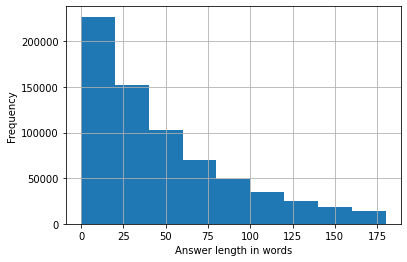

In [ ]:
ax = df['answer'].str.split(' ').str.len().hist(bins=range(0, 200, 20))
ax.set_xlabel('Answer length in words')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

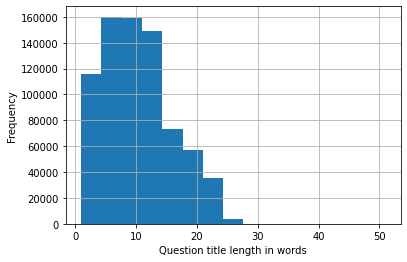

In [ ]:
ax = df['question'].str.split().str.len().hist(bins=15)
ax.set_xlabel('Question title length in words')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

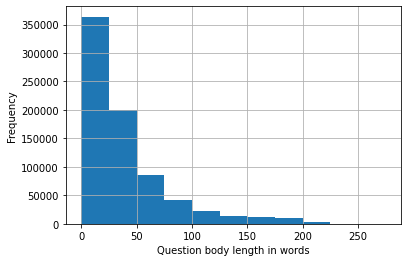

In [ ]:
ax = df['question2'].str.split().str.len().hist(bins=range(0,300, 25))
ax.set_xlabel('Question body length in words')
ax.set_ylabel('Frequency')

In [ ]:
df.groupby('label').count()['question']

label
1     85299
2     67700
3     77872
4     68381
5     75536
6     65859
7     62915
8     80177
9     88434
10    81482
Name: question, dtype: int64

In [ ]:
# # Downsample if needed for faster results
# sampleSize = 7536
# dfMin = df.head(sampleSize)
dfMin = df

In [ ]:
dfMin.head()

,label,question,question2,answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [ ]:
# Concatenate 3 fields into 1
combined = list(dfMin[['question', 'question2', 'answer']].apply(lambda x: '. '.join(x), axis=1))

In [ ]:
# Compute embeddings of all documents
textEmbeddings = getDocumentEmbedding(combined)

In [ ]:
# # Save embeddings for later use
# torch.save(textEmbeddings, 'YahooEmbeddingsFinal.pt')

In [ ]:
# # Load saved embeddings (if exist)
# textEmbeddings = torch.load('YahooEmbeddingsFinal.pt')

In [ ]:
textEmbeddings.shape

torch.Size([753655, 512])

## Visualization

For visualization in 2-dimensional space we use the SG-t-SNE algorithm from [3] that currently runs in Julia language, so we computed the 2D Embeddings there and we load it from a .mat file here

In [ ]:
!pip install hdf5storage

In [ ]:
import hdf5storage
mat = hdf5storage.loadmat('YahooDataset_sgtsnepi.mat')

In [ ]:
embeddings2D = mat['Y']

In [ ]:
embeddings2D.shape

(753655, 2)

In [ ]:
# Prepare the DataFrame to visualize
dfBokeh = pd.DataFrame(data={
    'x': embeddings2D[:, 0],
    'y': embeddings2D[:, 1],
    'text': list(df['question']),
    'label': list(df['label']),
    'labelText': list(df['labelText'])
})

In [ ]:
dfBokeh['color'] = 'black'
dfBokeh.loc[dfBokeh['label']==1   , 'color'] = 'lightcoral'
dfBokeh.loc[dfBokeh['label']==2   , 'color'] = 'khaki'
dfBokeh.loc[dfBokeh['label']==3   , 'color'] = 'lightskyblue'
dfBokeh.loc[dfBokeh['label']==4   , 'color'] = 'olive'
dfBokeh.loc[dfBokeh['label']==5   , 'color'] = 'red'
dfBokeh.loc[dfBokeh['label']==6   , 'color'] = 'thistle'
dfBokeh.loc[dfBokeh['label']==7   , 'color'] = 'mediumseagreen'
dfBokeh.loc[dfBokeh['label']==8   , 'color'] = 'sienna'
dfBokeh.loc[dfBokeh['label']==9   , 'color'] = 'navy'
dfBokeh.loc[dfBokeh['label']==10   , 'color'] = 'moccasin'

dfBokeh['size'] = 2

In [ ]:
# Bokeh Libraries
from bokeh.io import output_notebook, output_file, save
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, OpenURL, TapTool
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.models import TextInput, Button, Div, Slider, Paragraph
from bokeh.layouts import column, row
from bokeh import events
from bokeh.core.properties import value
from bokeh.events import MouseWheel
from bokeh.models.glyphs import Text, Circle, Glyph, ImageURL
from bokeh.util.browser import view
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6, Turbo256



# Output thevisualization directly in the notebook
output_notebook()
output_file(basePath + 'YahooEmbeddings.html')

In [ ]:
dfBokehSampled = dfBokeh.sample(200000)

In [ ]:
fig = figure(plot_height=850, plot_width=1000,
          match_aspect=True, title='2D embeddings of Yahoo!Answers Dataset documents')
# fig.title.text_font_style = 'bold'
# fig.title.align = 'center'

fig.xgrid.visible=False
fig.ygrid.visible=False

cds = ColumnDataSource(dfBokehSampled)
circleRenderer = fig.circle(x='x', y='y', legend='labelText', size=2, source=cds, color='color')

# # Format the tooltip
# tooltips = """
# <div style="width:400px;">
# @text
# </div>
# """
# # Add the HoverTool to the figure
# hover = HoverTool(tooltips=tooltips, renderers=[circleRenderer])
# fig.add_tools(hover)
show(fig)
save(fig)

## Artificial Label Mining

### Related Sentences from GPT-2

In [ ]:
# Generate new sentences from each label (topic)
relatedEmbeddings = []
relatedSentencesArr = []
nRelatedSentences = 50
for (iTopic, topic) in enumerate(topics):
  print(topic)
  relatedSentences = []

  for label in topic[0:1]:
    print(label)
    # Baseline
    relatedSentences = []
    relatedSentences.append(label)
    nRelatedSentences = 1
    relatedSentencesArr.append(relatedSentences)

    # # Enrichment
    # relatedSentences = relatedSentences + generate(model, prompt='In other news, ' + label.lower(), n=40, nSentences = int(nRelatedSentences/len(topic)))
    # relatedSentencesArr.append(relatedSentences)

  relatedEmbeddings.append(getEmbedding(relatedSentences))
  
  # # Optional: Save artifical labels and their embeddings for later use
  # np.save(topic[0]+'_USE', relatedEmbeddings[iTopic])
  # with open(topic[0]+'USE_Raw.txt', 'w') as f:
  #   f.write( '\n'.join(relatedSentences) )

['Society', 'Culture']
Society
['Science', 'Mathematics']
Science
['Health']
Health
['Education', 'Reference']
Education
['Computers', 'Internet']
Computers
['Sports']
Sports
['Business', 'Finance']
Business
['Entertainment', 'Music']
Entertainment
['Family', 'Relationship']
Family
['Politics', 'Government']
Politics


In [ ]:
# # Optional: Use saved artificial labels and embeddings (if exist)
# relatedEmbeddings = []
# relatedSentencesArr = []

# for (iTopic, topic) in enumerate(topics):
#   relatedEmbeddings.append(np.load(topic[0]+'_USE.npy'))

#   with open(topic[0]+'USE_Raw.txt', 'r') as f:
#     relatedSentencesArr.append(f.readlines())

In [ ]:
len(relatedEmbeddings[0])

50

## Prepare Inputs for Classification

In [ ]:
# Perform an optional PCA step to reduce dimensionality for faster results
n_components = 512
allEmbeddings = textEmbeddings

for (iTopic, topic) in enumerate(topics):
  allEmbeddings = np.concatenate([allEmbeddings, relatedEmbeddings[iTopic]])
print(allEmbeddings.shape)

pca = PCA(n_components=512)
embeddingsPCA = pca.fit_transform(allEmbeddings)

# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

nRelatedSentences = len(relatedEmbeddings[0])
print(nRelatedSentences)
nSentences = len(dfMin)
nTopics = len(topics)

relatedEmbeddingsPCA = []
for (iTopic, topic) in enumerate(topics):
  relatedEmbeddingsPCA.append( torch.tensor(embeddingsPCA[nSentences + iTopic*nRelatedSentences : nSentences+(iTopic+1)*nRelatedSentences]) )

embeddingsArr = torch.tensor(embeddingsPCA[0:nSentences])

### Maximum Similarity Classification

In [ ]:
probabilities = torch.zeros(size=(nSentences, nTopics))

for (iTopic, topic) in enumerate(topics):
  print(topic)
  evaluationEmbeddings = relatedEmbeddingsPCA[iTopic]

  meanScore, std, proba = evaluateEmbeddingsMultiple(embeddingsArr, evaluationEmbeddings)
  probabilities[:, iTopic]  = proba.T

ypred = torch.argmax(probabilities, dim=1) + 1

y = dfMin['label']

['Society', 'Culture']
['Science', 'Mathematics']
['Health']
['Education', 'Reference']
['Computers', 'Internet']
['Sports']
['Business', 'Finance']
['Entertainment', 'Music']
['Family', 'Relationship']
['Politics', 'Government']


In [ ]:
print(accuracy_score(y, ypred))

0.43155953320816554


In [ ]:
cm = confusion_matrix(y, ypred)
cmNorm = torch.tensor(data=cm, dtype=float)
for i in range(len(cm)):
  cmNorm[i, :] = cmNorm[i, :]/torch.sum(cmNorm[i, :])

Text(123.0, 0.5, 'Actual')

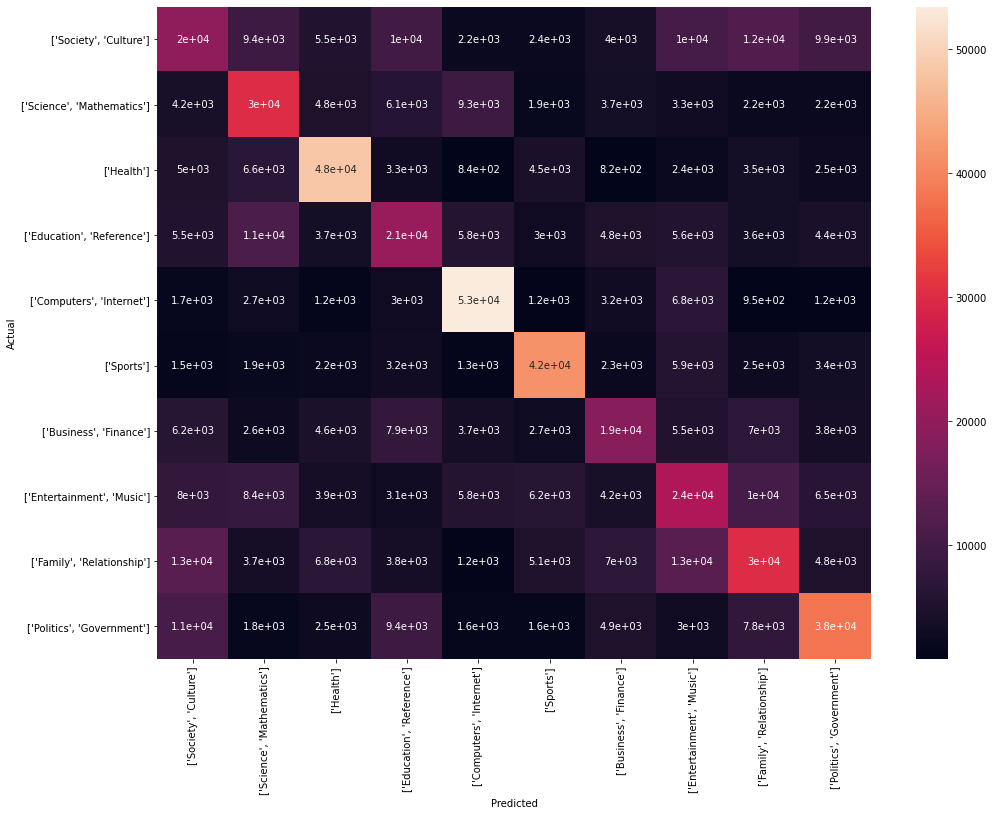

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, xticklabels=topics, yticklabels=topics)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
print(precision_score(y, ypred, average=None))
print('Precision: {:0.3f}'.format(np.mean(precision_score(y, ypred, average='weighted'))))

print(recall_score(y, ypred, average=None))
print('Recall: {:0.3f}'.format(np.mean(recall_score(y, ypred, average='weighted'))))

print(f1_score(y, ypred, average=None))
print('F1: {:0.3f}'.format(np.mean(f1_score(y, ypred, average='weighted'))))

[0.23683287 0.41458999 0.46039013 0.27591206 0.66945096 0.58811072
 0.44680245 0.5184895  0.45411242 0.48627845]
Precision: 0.460
[0.22577406 0.56691423 0.70207922 0.1729255  0.75842637 0.80831601
 0.19436183 0.5830837  0.60963479 0.46399489]
Recall: 0.473
[0.23117128 0.47893215 0.55610988 0.21260356 0.7111665  0.68085106
 0.2708864  0.54889276 0.52050473 0.4748754 ]
F1: 0.449


### kNN with cosine similarity
kNN libraries don't support cosine similarity as it is not a valid metric in the mathematical sense, so we implemented it ourselves

In [ ]:
# Construct distances matrix
X = torch.zeros(size=(nSentences, len(topics) * nRelatedSentences))

start = 0
for (iTopic, topic) in enumerate(topics):
  print(topic)

  relatedEmbeddingsArr = relatedEmbeddingsPCA[iTopic]

  for iSentence in range(nSentences):
    nextFree = start
    for iKeyword in range(nRelatedSentences):
      X[iSentence][nextFree] = getSimilarity(embeddingsArr[iSentence], relatedEmbeddingsArr[iKeyword])
      nextFree += 1

  start += nRelatedSentences

Society
Science
Health
Education
Computers
Sports
Business
Entertainment
Family
Politics


In [ ]:
ypred = np.zeros((nSentences, ))
y = np.asarray(dfMin['label'])

acc  = []
prec = []
rec  = []
f1   = []
rng = range(1, 200, 10)
for k in rng:
  for i in range(nSentences):
    idx = np.argpartition(X[i, :], -k)[-k:]

    tmpIdx = idx.clone().detach()

    tmpIdx[idx>=9*nRelatedSentences] = 10
    idx[idx>=9*nRelatedSentences] = -1

    tmpIdx[idx>=8*nRelatedSentences] = 9
    idx[idx>=8*nRelatedSentences] = -1

    tmpIdx[idx>=7*nRelatedSentences] = 8
    idx[idx>=7*nRelatedSentences] = -1

    tmpIdx[idx>=6*nRelatedSentences] = 7
    idx[idx>=6*nRelatedSentences] = -1

    tmpIdx[idx>=5*nRelatedSentences] = 6
    idx[idx>=5*nRelatedSentences] = -1

    tmpIdx[idx>=4*nRelatedSentences] = 5
    idx[idx>=4*nRelatedSentences] = -1
    
    tmpIdx[idx>=3*nRelatedSentences] = 4
    idx[idx>=3*nRelatedSentences] = -1

    tmpIdx[idx>=2*nRelatedSentences] = 3
    idx[idx>=2*nRelatedSentences] = -1

    tmpIdx[idx>=1*nRelatedSentences] = 2
    idx[idx>=1*nRelatedSentences] = -1

    tmpIdx[idx>=0*nRelatedSentences] = 1
    idx[idx>=0*nRelatedSentences] = -1

    ypred[i] = torch.mode(tmpIdx).values.item()

  acc.append(accuracy_score(y, ypred))
  prec.append(precision_score(y, ypred, average='weighted'))
  rec.append(recall_score(y, ypred, average='weighted'))
  f1.append(f1_score(y, ypred, average='weighted'))


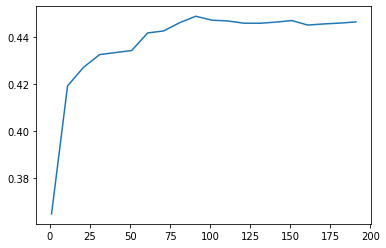

In [ ]:
plt.plot(rng, f1)

In [ ]:
idx = np.argmax(f1)
k = rng[idx]

print(k)
print('Precision: {:0.3f}'.format(prec[idx]))
print('Recall: {:0.3f}'.format(rec[idx]))
print('F1: {:0.3f}'.format(f1[idx]))


91
Precision: 0.459
Recall: 0.453
F1: 0.449


### kNN with distance metrics

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
nRelatedSentencesArr = [nRelatedSentences]*nTopics
X = np.zeros((sum(nRelatedSentencesArr), 50))
ytrain = np.zeros((sum(nRelatedSentencesArr), 1))
for (iTopic, topic) in enumerate(topics):
  X[sum(nRelatedSentencesArr[0:iTopic]) : sum(nRelatedSentencesArr[0:iTopic+1]), :] = relatedEmbeddingsPCA[iTopic]
  ytrain[sum(nRelatedSentencesArr[0:iTopic]) : sum(nRelatedSentencesArr[0:iTopic+1])] = iTopic + 1

In [ ]:
acc = []
for k in range(2, 100, 5):
  knn = KNeighborsClassifier(n_neighbors=k, p=2, weights='distance')
  knn.fit(X, ytrain)
  ypred = knn.predict(embeddingsArr)
  acc.append(accuracy_score(y, ypred))

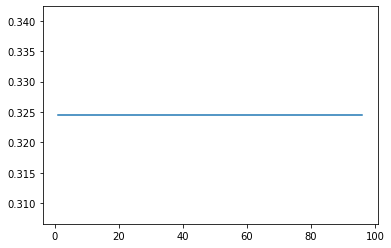

In [ ]:
plt.plot(range(1, 100, 5), acc)